In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [ ]:
# Load the dataset
df = pd.read_csv("customer_booking.csv", encoding='latin1')

# --- 1. Initial Exploration and Cleaning ---
# Standardize column names (optional but good practice)
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Drop 'route' as it has too many unique values (too high cardinality)
# and is often difficult to interpret in a general model.
df.drop('route', axis=1, inplace=True)

# Clean up 'flight_day' column
df['flight_day'] = df['flight_day'].str.strip()





In [ ]:
# --- 2. Feature Engineering ---
# 2.1. Feature: Interaction of Length of Stay and Purchase Lead
# Bookings with very short lead times and short stays might be urgent.
df['lead_stay_ratio'] = df['purchase_lead'] / (df['length_of_stay'] + 1e-6) # Add epsilon to avoid division by zero
# Binning to manage skewness and outliers in ratio
df['lead_stay_ratio_binned'] = pd.cut(df['lead_stay_ratio'], bins=[-np.inf, 0.5, 1, 2, 5, np.inf], labels=['V_Short_Lead', 'Short_Lead', 'Medium_Lead', 'Long_Lead', 'V_Long_Lead'])



In [ ]:
# 2.2. Feature: Simplification of Booking Origin (High-level regions)
# Map countries to continents/regions to reduce cardinality
country_to_region = {
    'Malaysia': 'SE_Asia', 'New Zealand': 'Oceania', 'India': 'Asia', 'Australia': 'Oceania',
    'United Kingdom': 'Europe', 'China': 'Asia', 'South Korea': 'Asia', 'Japan': 'Asia',
    'Taiwan': 'Asia', 'United States': 'N_America', 'Singapore': 'SE_Asia', 'Thailand': 'SE_Asia',
    'Hong Kong': 'Asia', 'Germany': 'Europe', 'Canada': 'N_America', 'Samoa': 'Oceania',
    'Macau': 'Asia', 'Indonesia': 'SE_Asia', 'Philippines': 'SE_Asia', 'Vietnam': 'SE_Asia',
    'Bermuda': 'N_America', 'Brunei': 'SE_Asia', 'Iran': 'Middle_East', 'Switzerland': 'Europe',
    'Czech Republic': 'Europe', 'Nepal': 'Asia', 'Netherlands': 'Europe', 'Finland': 'Europe',
    'Mozambique': 'Africa', 'Israel': 'Middle_East', 'Mexico': 'N_America', 'Spain': 'Europe',
    'France': 'Europe', 'Hawaii': 'Oceania', 'Managed to get an extension': 'Other', # Treat as 'Other'
    'Belgium': 'Europe', 'Northern Mariana Islands': 'Oceania', 'Lebanon': 'Middle_East',
    'Ireland': 'Europe', 'Qatar': 'Middle_East', 'Oman': 'Middle_East', 'Tonga': 'Oceania',
    'United Arab Emirates': 'Middle_East', 'Kazakhstan': 'Asia', 'Kyrgyzstan': 'Asia',
    'Saudi Arabia': 'Middle_East', 'Kuwait': 'Middle_East', 'Turkey': 'Europe',
    'Denmark': 'Europe', 'Sweden': 'Europe', 'Papua New Guinea': 'Oceania', 'Norway': 'Europe',
    'Mongolia': 'Asia', 'Azerbaijan': 'Asia', 'Belarus': 'Europe', 'Bulgaria': 'Europe',
    'Cambodia': 'SE_Asia', 'Egypt': 'Africa', 'Estonia': 'Europe', 'Gibraltar': 'Europe',
    'Guam': 'Oceania', 'Hungary': 'Europe', 'Kenya': 'Africa', 'Laos': 'SE_Asia',
    'Luxembourg': 'Europe', 'Malta': 'Europe', 'Mauritius': 'Africa', 'New Caledonia': 'Oceania',
    'Nigeria': 'Africa', 'Panama': 'N_America', 'Portugal': 'Europe', 'Romania': 'Europe',
    'Slovakia': 'Europe', 'Slovenia': 'Europe', 'South Africa': 'Africa', 'Sri Lanka': 'Asia',
    'Tanzania': 'Africa', 'Bahrain': 'Middle_East', 'Reunion': 'Africa', 'Guatemala': 'N_America',
    'Vanuatu': 'Oceania', 'Croatia': 'Europe', 'Armenia': 'Asia', 'Russia': 'Europe',
    'Dominican Republic': 'N_America', 'Fiji': 'Oceania', 'Italy': 'Europe',
    'Marshall Islands': 'Oceania', 'Uzbekistan': 'Asia', 'Zimbabwe': 'Africa',
    'Chile': 'S_America', 'Colombia': 'S_America', 'Ecuador': 'S_America', 'Ghana': 'Africa',
    'Greece': 'Europe', 'Jordan': 'Middle_East', 'Peru': 'S_America', 'Puerto Rico': 'N_America',
    'Seychelles': 'Africa', 'Singapore-': 'SE_Asia', # Clean up 'Singapore-'
    'Argentina': 'S_America', 'Ethiopia': 'Africa', 'Norfolk Island': 'Oceania',
    'Cote d Ivoire': 'Africa', 'Cyprus': 'Europe', 'Georgia': 'Asia', 'Iceland': 'Europe',
    'Togo': 'Africa', 'Ukraine': 'Europe', 'Brazil': 'S_America', 'Sint Maarten': 'N_America',
    'United Kingdom-': 'Europe', 'Curaçao': 'N_America', 'East Timor': 'SE_Asia',
    'French Polynesia': 'Oceania', 'Jersey': 'Europe', 'Morocco': 'Africa',
    'Republic of North Macedonia': 'Europe', 'The Netherlands': 'Europe', 'Togo-': 'Africa',
    'Americana Samoa': 'Oceania', 'Angola': 'Africa', 'Congo (Brazzaville)': 'Africa',
    'Guyana': 'S_America', 'Isle of Man': 'Europe', 'Liberia': 'Africa', 'Maldives': 'Asia',
    'Malawi': 'Africa', 'North Korea': 'Asia', 'Palau': 'Oceania', 'Svalbard & Jan Mayen': 'Europe',
    'Trinidad and Tobago': 'N_America', 'Yemen': 'Middle_East', 'Zambia': 'Africa'
}
# Fallback for any unmapped countries to 'Other'
df['booking_region'] = df['booking_origin'].apply(lambda x: country_to_region.get(x, 'Other'))




In [ ]:
# 2.3. Feature: Extra Services Requested
# Sum of binary 'wants' columns
wants_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
df['num_extra_services'] = df[wants_cols].sum(axis=1)



In [ ]:
# --- 3. Encoding Categorical Variables ---
# Select columns for One-Hot Encoding
categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'booking_region', 'lead_stay_ratio_binned']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop original columns used for region and origin (booking_origin is high-cardinality)
df_encoded.drop(['booking_origin', 'lead_stay_ratio'], axis=1, inplace=True)

# Final features and target
X = df_encoded.drop('booking_complete', axis=1)
y = df_encoded['booking_complete']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
# --- 4. Model Training and Evaluation ---

# Initialize the Random Forest Classifier
# Adjusting class weight to handle the class imbalance (booking_complete is ~15%)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=10, min_samples_leaf=5)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [4]:
print("--- Test Set Evaluation Metrics ---")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Test Set):\n", cm)

# Cross-Validation (5-fold)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
print(f"\n5-Fold Cross-Validation (ROC AUC): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

--- Test Set Evaluation Metrics ---
ROC AUC Score: 0.7496

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80      8379
           1       0.28      0.66      0.40      1478

    accuracy                           0.70      9857
   macro avg       0.60      0.68      0.60      9857
weighted avg       0.83      0.70      0.74      9857


Confusion Matrix (Test Set):
 [[5914 2465]
 [ 498  980]]

5-Fold Cross-Validation (ROC AUC): 0.5640 (+/- 0.1953)


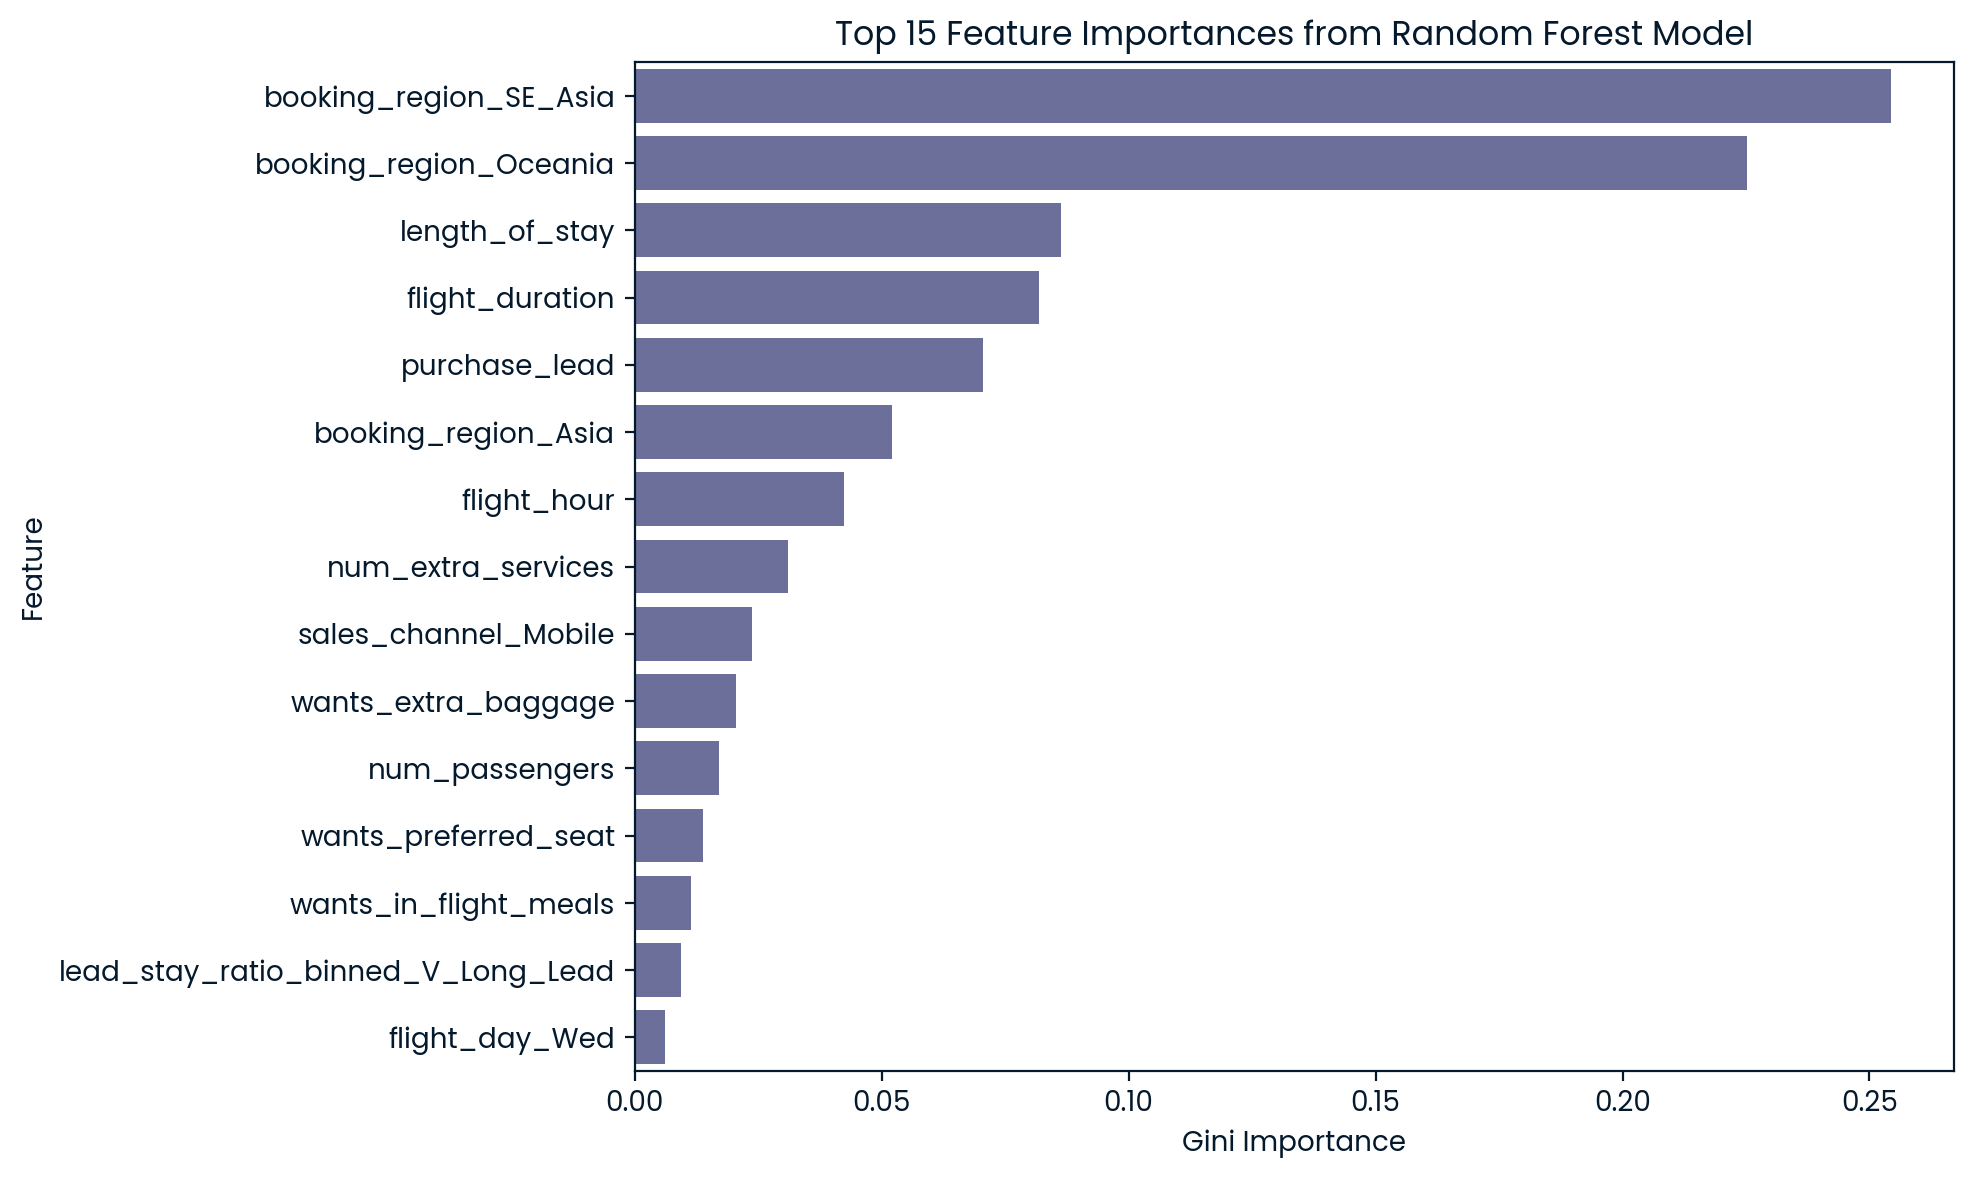

In [5]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Select the top 15 features for visualization
top_n = 15
forest_importances_top = forest_importances.head(top_n)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances_top.values, y=forest_importances_top.index)
plt.title(f"Top {top_n} Feature Importances from Random Forest Model")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()